# Lesson 4

We will be exploring a famous data set, known as the Titanic data set. Using this data, we will attempt to predict survival of a Titanic passenger.

**Goal**

After this lesson, you should:
1. Understand the following concepts:
    - random forests
    - decision trees
   
-----

Resources:
- https://www.kaggle.com/c/titanic

Data set for today's lecture:
- http://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv

In [1]:
import numpy as np
import pandas as pd
import sklearn as skl
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sea

# control the plotsize
plt.rcParams['figure.figsize'] = [10,5]

# CART Algorithm

> **CART**: Classification and Regression Trees

A _very_ robust methodology to help make both classification and regression predictions uses trees. These algorithms are the closest thing you will get which are just "ready to go", and require minimal tuning/engineering.

Intuitively, we call these data structures, **Decision Trees**.

<img src="https://cdn-images-1.medium.com/max/569/0*Yclq0kqMAwCQcIV_.jpg" width="350">



Decision trees are great because they:

- implicitly perform feature selection
- handle _both_ numerical and categorical data
- require almost no real engineering effort
- don't have performance characteristics which are affected by nonlinear relationships

### How do we grow a decision tree?

The size of the tree depends on:
- which features it chooses
- what conditions are used for "splitting"
- what conditions are used for "stopping"

As the tree grows, it becomes prone to _overfitting_. We don't want an arbitrarily large tree, so we need to reduce its size somehow.

> Consider an example where we train a Decision Tree on 3 features. This means there will be 3 candidate splits. In this case we adopt the following process:

1. calculate the _accuracy_ of a split using some cost function
2. choose the split which costs the least
3. recurse into the sub-groups and perform steps 1 and 2

### Cost Functions
We can use decision trees in regression and classification analysis. For now, we will focus on a popular and robust cost function for classification models.

**Gini Cost Function**

> Intuition: How mixed are the classes on which we want to split?

For each child node, we calculate: $G(t) = 1 - \sum{\text{prop}^2}$, where _prop_ is the proportion of classes in each group. In other words, we just want to minimize the impurity of a split by grouping together as many similar classes as possible.

<img src="https://dimensionless.in/wp-content/uploads/RandomForest_blog_files/figure-html/gini.png" width="1000">


### When do we stop splitting?

If we have too many features, we will end up with a very large tree, and this leads to overfitting.

> lots of features $\rightarrow$ large tree $\rightarrow$ overfitting

We define our stopping points in two main ways:

1. set a minimum number of training inputs for each leaf
2. set a maximum depth to traverse the tree

<img src="https://www.includehelp.com/data-structure-tutorial/images/Image5.gif" width="500">

We can further prevent overfiting by **pruning** the tree. This just means that we remove branches that make use of features that have low importance. We can do this my either:

1. reducing complexity, which increases the predictive power by reducing any overfitting
2. using more complicated methods, such as _reduced error pruning_ or _weakest link pruning_. These methods are beyond our scope, but feel free to look them up.

## Random Forests

Random forests are a relatively black box construct which gives _fantastic_ results for _minimal effort_. Of all the standard algorithms we will learn, this is the one that most likely "just works."

At its core, the Random Forests algorithm builds many Decision Trees and then merges them together by "voting" on the best ones. Compared to Decision Trees, Random Forests is both (1) more accurate and (2) more stable.

<img src="https://i0.wp.com/analyticsdefined.com/wp-content/uploads/2018/01/random-forests.png?fit=1965%2C942&ssl=1" width="1000">

| Decision Trees |**vs**| Random Forests |
|----------------|----|----------------|
| put features into DT $\rightarrow$ predict rules |**vs**| randomly select features $\rightarrow$ build several DTs $\rightarrow$ avg results |
| large DT $\rightarrow$ overfitting | **vs** | much harder to overfit b/c randomly selects features, builds subsets, and combine |

#### Important Hyperparameters

**hyperparameters** are a few values which control the overall performance of the algorithm. Adjusting these parameters will drastically effect how well and quickly the model "learns."

You should be aware of the following hyperparameters when using Random Forests:

##### Predictive Power
1. **n_estimators**: the number of decision trees to build before averaging
1. **max_features**: the maximum features in an individual decision tree
1. **min_samples_split**: the minimum number of samples required to split at an internal node
1. **min_samples_leaf**: the minimum samples required to be at a leaf node

##### Speed
1. **n_jobs**: how many processors are available to your model (where $-1$ means there is no limit)
1. **random_state**: the seed used by the random number generator. The same seed will provide the same results given the same parameters and training data.
1. **oob_score**: a special score that serves as cross validation for random forests. It takes advantage of a property in random forests that reserves ~33% of the data which is not used to train the model.

In [2]:
# Let's implement the Random Forests algorithm using the titanic data set

raw = pd.read_csv('./data/titanic.csv')
raw.head(10)

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
5,0,3,Mr. James Moran,male,27.0,0,0,8.4583
6,0,1,Mr. Timothy J McCarthy,male,54.0,0,0,51.8625
7,0,3,Master. Gosta Leonard Palsson,male,2.0,3,1,21.0750
8,1,3,Mrs. Oscar W (Elisabeth Vilhelmina Berg) Johnson,female,27.0,0,2,11.1333
9,1,2,Mrs. Nicholas (Adele Achem) Nasser,female,14.0,1,0,30.0708


In [3]:
raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Survived,887.0,0.385569,0.487004,0.00,0.000,0.0000,1.0000,1.0000
Pclass,887.0,2.305524,0.836662,1.00,2.000,3.0000,3.0000,3.0000
Age,887.0,29.471443,14.121908,0.42,20.250,28.0000,38.0000,80.0000
Siblings/Spouses Aboard,887.0,0.525366,1.104669,0.00,0.000,0.0000,1.0000,8.0000
Parents/Children Aboard,887.0,0.383315,0.807466,0.00,0.000,0.0000,0.0000,6.0000
Fare,887.0,32.305420,49.782040,0.00,7.925,14.4542,31.1375,512.3292


In [6]:
raw.columns = raw.columns.map(lambda x: x.lower())

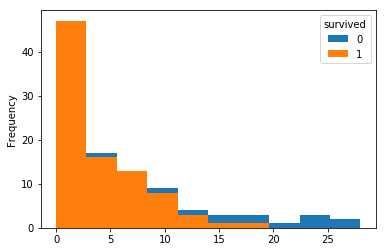

In [8]:
pd.crosstab(raw['age'],raw['survived']).plot(kind='hist')

In [9]:
data = pd.get_dummies(raw, columns=['sex','pclass'])
data = data.drop(columns=['name'],axis=1)

In [10]:
X = data[data.columns.values[1:]]
y = data['survived']

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [12]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(oob_score=True)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [13]:
forest.fit(X_train, y_train)

/home/oliver/environments/my_env/lib/python3.5/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/oliver/environments/my_env/lib/python3.5/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [14]:
forest.oob_score_

0.7729323308270677

In [15]:
y_scores = forest.predict_proba(X_train)
y_scores = y_scores[:,1]


In [16]:
from sklearn.metrics import roc_curve

fpr, tpr, ths = roc_curve(y_train, y_scores)

Text(0,0.5,'True Positive Rate')

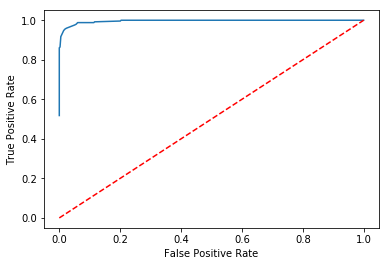

In [17]:
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')